# Simulation without photovoltaic panels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import poisson
from joblib import Parallel, delayed
import time
import sys
from scipy.optimize import minimize, Bounds, LinearConstraint, minimize_scalar

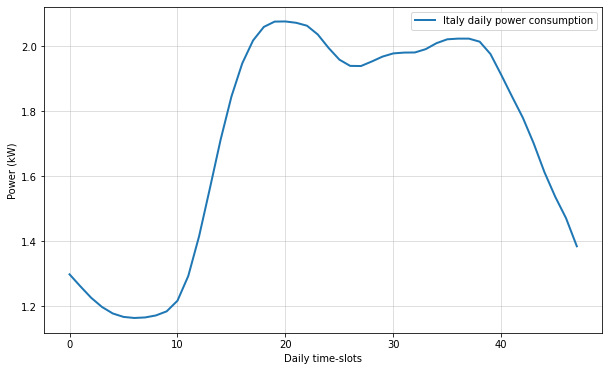

In [2]:
# Import the load profile
load_curve = np.loadtxt('data/load_agg_data.csv', delimiter=',', skiprows=1)[:, 2] * 4.1
plt.figure(figsize=(10,6))
plt.plot(load_curve, lw=2, label='Italy daily power consumption')
#plt.hlines(y=0.43, xmin=0, xmax=48, ls='dashed', label='EU average per dwelling')
plt.xlabel('Daily time-slots')
plt.ylabel('Power (kW)')
plt.grid(alpha=0.5)
plt.legend()

In [52]:
print(load_curve[7], load_curve[20])

1.16481 2.0770599999999995


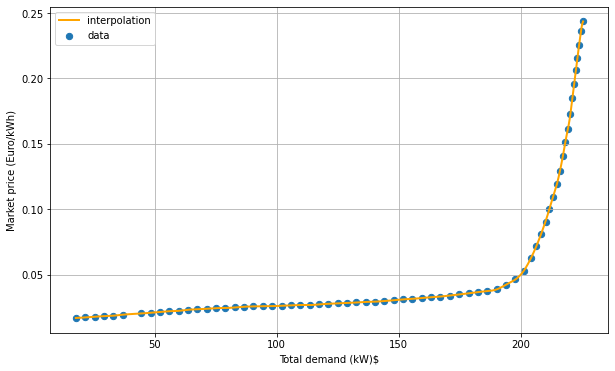

In [23]:
# Import market price (MW, Euro/MWh)
from scipy.interpolate import interp1d
market_price_data = np.loadtxt('data/market_price_UK.csv', delimiter=',')

# rescaling of the total demand to fit the simulation
tot_demand = market_price_data[:, 0] * 100 - 210

market_price = interp1d(tot_demand, market_price_data[:, 1] / 1000, kind='cubic')
x = np.linspace(tot_demand[0], tot_demand[-1], 600)
plt.figure(figsize=(10,6))
plt.scatter(tot_demand, market_price_data[:, 1] / 1000, s=40, label='data')
plt.plot(x, market_price(x), lw=2, label='interpolation', c='orange')
plt.xlabel(r'Total demand (kW)$')
plt.ylabel('Market price (Euro/kWh)')
plt.legend()
plt.grid()

### Functions

In [127]:
# Customer's utility function: for optimizing wrt b_pm
def u_b(b_pm, p, l, e):
    """
    b_pm: charging profile (1x2T)
    p: price vector (1xT)
    b_m: discharging profile (1xT)
    l: load profile (1xT)
    c: running cost of storage
    e: storage capacity 
    """
    return np.sum(p * (b_pm[:T] - alpha * b_pm[T:] + l))

def constr_matrix_b(alpha):
    """
    alpha: efficiency
    """
    # storage efficiency
    mat1 = np.zeros(shape=(1, 2*T), dtype='float')
    for j in range(T):
        #mat1[0, j] = -alpha
        mat1[0, j] = -1
        mat1[0, j+T] = 1

    # within charging and discharging capacity
    mat2 = np.hstack([np.identity(T, dtype='float'), np.zeros(shape=(T, T), dtype='float')])
    mat3 = np.hstack([np.zeros(shape=(T, T), dtype='float'), np.identity(T, dtype='float')])

    # energy that can be stored or used at a time slot
    mat4 = np.zeros(shape=(T, 2*T), dtype='float')
    for i in range(1, T):
        #mat4[i, :i] = -alpha
        #mat4[i, T:T+i] = alpha
        mat4[i, :i] = -1
        mat4[i, T:T+i] = 1
    for i in range(T):
        mat4[i, T+i] = 1

    mat5 = np.zeros(shape=(T, 2*T), dtype='float')
    for i in range(1, T):
        mat5[i, :i] = 1
        mat5[i, T:T+i] = -1
    for i in range(T):
        mat5[i, i] = 1    

    return np.vstack([mat1, mat2, mat3, mat4, mat5, mat3])

def constr_vectors_b(b_sup, b_inf, alpha, e0, e, l):
    """
    n: customer's index
    """
    # left
    leftv1 = np.zeros(1)          # bilateral
    leftv2 = np.zeros(T)          # bilateral
    leftv3 = np.zeros(T)          # bilateral
    leftv4 = -np.ones(T)*np.inf   # unilateral
    leftv5 = -np.ones(T)*np.inf   # unilateral
    leftv_constr = np.concatenate([leftv1, leftv2, leftv3, leftv4, leftv5, leftv3])

    # right
    rightv_constr = np.concatenate([[0], [b_sup] * T, [b_inf] * T, [e0] * T, [e - e0] * T, l])
    return leftv_constr, rightv_constr

def optimize_b(b_sup, b_inf, p, alpha, e0, e, l, x0):
    mat_constr = constr_matrix_b(alpha)
    leftv_constr, rightv_constr = constr_vectors_b(b_sup, b_inf, alpha, e0, e, l)
    linear_constraint = LinearConstraint(mat_constr, leftv_constr, rightv_constr)
    bounds = Bounds([0] * 2 * T, [max(b_sup, b_inf)] * 2 * T)
    b_opt = minimize(u_b, x0, args=(p, l, e), method='trust-constr',
        constraints=linear_constraint,
        bounds=bounds,
        options={'verbose' : 0})
    return b_opt.x

### Parameters

In [144]:
n_nodes = 30
n_smart = 30
T = 48                                      # number of time slots in a day(1 slot = 0.5 hours)
n_days = 50                                 # number of days to simulate 
beta = 0.1                                 # storage profile learning rate
b_inf = 0.2                                 # Maximum discharge in a time slot (kWh)
b_sup = 0.2                                 # Maximum charge in a time slot(kWh)
alpha = 0.8                                 # efficiency

In [145]:
# try with another price function
from scipy.stats import linregress
y_val = [0.27862, 0.32154]
x_val = [load_curve[7] * n_nodes, load_curve[20] * n_nodes]
res = linregress(x_val, y_val)
intercept = res.intercept
slope = res.slope
def market_price(load):
    return intercept + slope * load * 3

In [146]:
# Intialization
e0 = np.zeros(n_smart)                  # storage level
e = 3.                                  # storage capacity
b_pm = np.zeros(shape=(n_smart, 2*T))   # charging profiles
l = np.zeros(shape=(n_nodes, T))        # load profiles
b_history = np.ndarray(shape=(0, T))    # storage profile history
p_history = np.ndarray(shape=(0, T))    # price history

# generate load profiles
sigma = 0.005
for i in range(n_nodes):
    l[i, :] = load_curve[(poisson.rvs(mu=2, size=T) + np.arange(T)) % T] + np.random.randn(T)*sigma

p = market_price(l.sum(axis=0) - alpha * b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))
p_history = np.append(p_history, [p], axis=0)
u_history = np.ndarray(shape=(0, 48))
x0 = np.zeros(shape=(n_smart, 2*T))

### Simulation

In [147]:
for d in range(n_days):
    t_start = time.time()
    b_opt = np.ndarray(shape=(0, 2*T))

    # optimize b
    with Parallel(n_jobs=n_smart) as parallel:
        b_opt_list = parallel(delayed(optimize_b)(b_sup, b_inf, p, alpha, e0[n], e, l[n, :], x0[n]) for n in range(n_smart))
    for n in range(n_smart):
        b_opt = np.append(b_opt, [b_opt_list[n]], axis=0)

    # update b
    b_pm = b_pm + beta * (b_opt - b_pm)
    x0 = b_opt

    # update e0
    e0 = e0 + b_pm[:, :T].sum() - b_pm[:, T:].sum()

    b_history = np.append(b_history, [np.mean(b_pm[:, :T] - b_pm[:, T:], axis=0)], axis=0)
    p = market_price(l.sum(axis=0) - alpha * b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))
    p_history = np.append(p_history, [p], axis=0)
    u_prof = [p * (l[:n_smart, :].mean(axis=0) - alpha * b_pm[:, T:].mean(axis=0) + b_pm[:, :T].mean(axis=0))]
    u_history = np.append(u_history, u_prof, axis=0)
    t_stop = time.time()
    time_elapsed = round((t_stop - t_start)/60, 2)
    print('completed day {d}/{n_days} in {mins} min'.format(d=d+1, n_days=n_days, mins=time_elapsed))

completed day 1/50 in 0.18 min
completed day 2/50 in 0.17 min
completed day 3/50 in 0.17 min
completed day 4/50 in 0.16 min
completed day 5/50 in 0.16 min
completed day 6/50 in 0.16 min
completed day 7/50 in 0.16 min
completed day 8/50 in 0.16 min
completed day 9/50 in 0.17 min
completed day 10/50 in 0.17 min
completed day 11/50 in 0.17 min
completed day 12/50 in 0.19 min
completed day 13/50 in 1.05 min
completed day 14/50 in 1.2 min
completed day 15/50 in 1.06 min
completed day 16/50 in 0.18 min
completed day 17/50 in 0.17 min
completed day 18/50 in 0.18 min
completed day 19/50 in 0.16 min
completed day 20/50 in 0.16 min
completed day 21/50 in 0.16 min
completed day 22/50 in 0.16 min
completed day 23/50 in 0.17 min
completed day 24/50 in 0.18 min
completed day 25/50 in 0.18 min
completed day 26/50 in 1.25 min
completed day 27/50 in 1.26 min
completed day 28/50 in 2.02 min
completed day 29/50 in 0.19 min
completed day 30/50 in 0.18 min
completed day 31/50 in 0.16 min
completed day 32/5

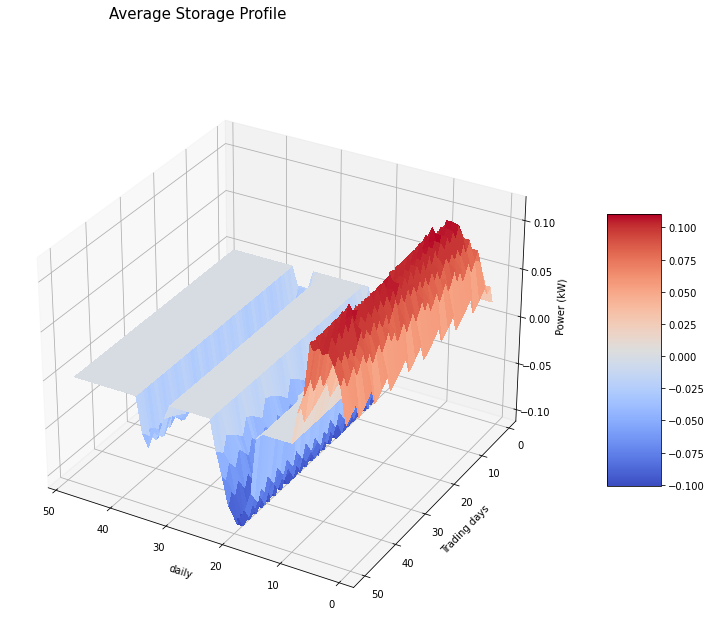

In [148]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,10))
X = np.arange(1, T+1, 1)
Y = np.arange(1, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, b_history, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('Trading days', size=10)
ax.set_xlabel('daily', size=10)
ax.set_zlabel('Power (kW)', size=10)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
fig.suptitle('Average Storage Profile', size=15);

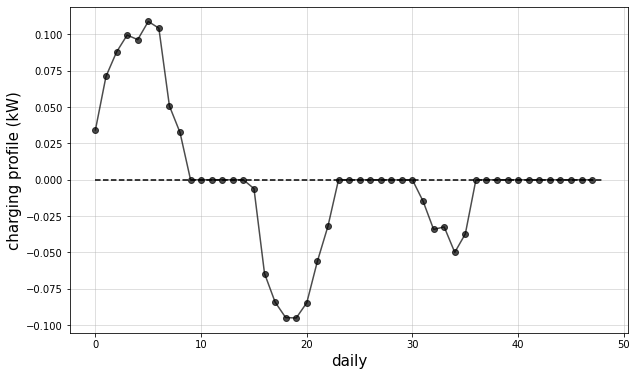

In [149]:
plt.figure(figsize=(10,6))
plt.xlabel('daily', size=15)
plt.ylabel('charging profile (kW)', size=15)
plt.hlines(xmin=0, xmax=48, y=0., ls='dashed', color='black')
plt.plot(b_history[-1], '-o', c='black', alpha=0.7);
plt.grid(alpha=0.5)

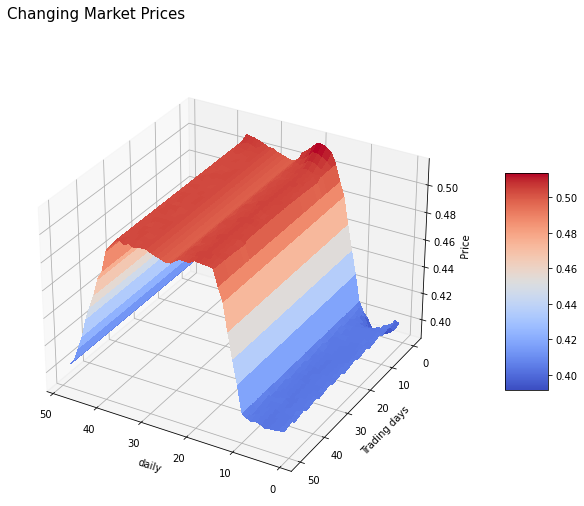

In [150]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,8))
X = np.arange(1, T+1, 1)
Y = np.arange(0, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, p_history, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('Trading days', size=10)
ax.set_xlabel('daily', size=10)
ax.set_zlabel('Price', size=10)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
fig.suptitle('Changing Market Prices', size=15);

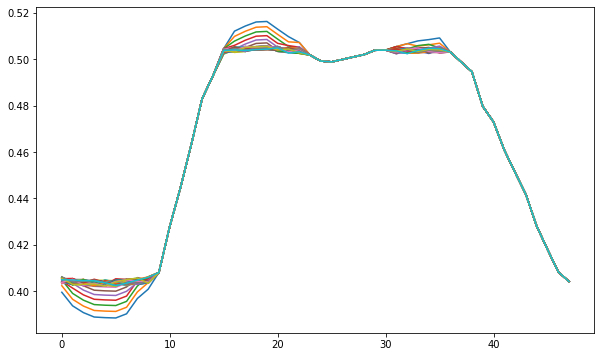

In [151]:
plt.figure(figsize=(10,6))
for d in range(n_days):
    plt.plot(p_history[d, :])

Text(0.5, 0, 'trading day')

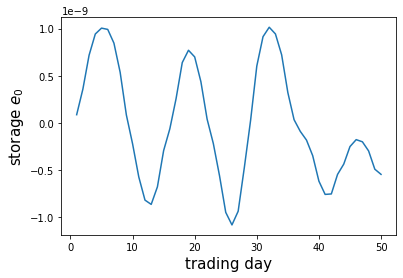

In [152]:
e0 = np.cumsum(b_history.sum(axis=1))
plt.plot(np.arange(1,51,1), e0)
plt.ylabel(r'storage $e_0$', size=15)
plt.xlabel('trading day', size=15)

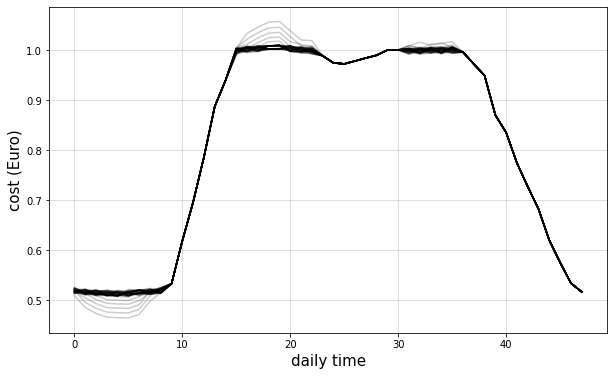

In [153]:
plt.figure(figsize=(10,6))
for i in range(n_days-1):
    plt.plot(u_history[i, :], c='black', alpha=0.2)
plt.plot(u_history[-1, :], c='black')
plt.xlabel('daily time', size=15)
plt.ylabel('cost (Euro)', size=15)
plt.grid(alpha=0.5)

Text(0, 0.5, 'cost (Euro)')

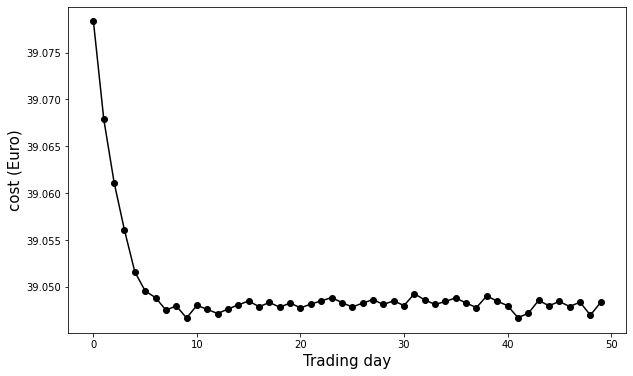

In [154]:
plt.figure(figsize=(10,6))
plt.plot(u_history.sum(axis=1), '-o', c='black')
plt.xlabel('Trading day', size=15)
plt.ylabel('cost (Euro)', size=15)


In [139]:
np.savetxt('Results/b_history-{dd}d.npy'.format(dd=n_days), b_history)
np.savetxt('Results/p_history-{dd}d.npy'.format(dd=n_days), p_history)
np.savetxt('Results/u_history-{dd}d.npy'.format(dd=n_days), u_history)